In [1]:
import os
import math
import torch
import numpy as np
import copy
import laspy

import matplotlib.pyplot as plt

In [7]:
%cd pc

/csghome/sm330/pc


In [22]:
path1 = r"data/20240607_trees_refined.laz"
path2 = r"data/20250613_trees_refined.laz"
device = "cuda" if torch.cuda.is_available() else "cpu"
voxel_size = 0.01

In [30]:
las = laspy.read(path1)
x = las.x * las.header.scale[0] + las.header.offset[0]
y = las.y * las.header.scale[1] + las.header.offset[1]
z = las.z * las.header.scale[2] + las.header.offset[2]
pts = np.vstack((x, y, z)).T.astype(np.float32)

In [31]:
pts[:10]

array([[4.7415376e+03, 5.4651797e+04, 1.5195000e+00],
       [4.7415425e+03, 5.4651797e+04, 1.5194000e+00],
       [4.7415381e+03, 5.4651797e+04, 1.5196000e+00],
       [4.7415405e+03, 5.4651801e+04, 1.5192000e+00],
       [4.7415547e+03, 5.4651801e+04, 1.5315000e+00],
       [4.7415552e+03, 5.4651801e+04, 1.5312999e+00],
       [4.7415454e+03, 5.4651805e+04, 1.5290999e+00],
       [4.7415488e+03, 5.4651809e+04, 1.5246000e+00],
       [4.7415483e+03, 5.4651805e+04, 1.5247999e+00],
       [4.7415483e+03, 5.4651809e+04, 1.5232000e+00]], dtype=float32)

In [32]:
pts2 = np.vstack((las.x, las.y, las.z)).T.astype(np.float32)
pts2[:10]

array([[4.7415378e+05, 5.4651795e+06, 1.5195000e+02],
       [4.7415422e+05, 5.4651795e+06, 1.5194000e+02],
       [4.7415381e+05, 5.4651795e+06, 1.5196001e+02],
       [4.7415403e+05, 5.4651800e+06, 1.5192000e+02],
       [4.7415547e+05, 5.4651800e+06, 1.5314999e+02],
       [4.7415553e+05, 5.4651800e+06, 1.5313000e+02],
       [4.7415453e+05, 5.4651805e+06, 1.5291000e+02],
       [4.7415488e+05, 5.4651810e+06, 1.5246001e+02],
       [4.7415484e+05, 5.4651805e+06, 1.5248000e+02],
       [4.7415481e+05, 5.4651810e+06, 1.5232001e+02]], dtype=float32)

In [ ]:
# bounds & grid shape
pts = torch.from_numpy(pts.astype(np.float32)).to(device)
mins = torch.min(pts, dim=0).values  # (3,)
maxs = torch.max(pts, dim=0).values
grid_size = torch.ceil((maxs - mins) / voxel_size).long()

In [ ]:
grid_size

tensor([30, 27,  5], device='cuda:0')

In [ ]:
nx, ny, nz = int(grid_size[0].item()), int(grid_size[1].item()), int(grid_size[2].item())
if nx <= 0 or ny <= 0 or nz <= 0:
    raise ValueError("Voxel grid has zero size; check voxel_size or point cloud extents.")

In [ ]:
# compute voxel indices
rel = (pts - mins) / voxel_size
idx3 = torch.floor(rel).long()  # (N,3) indices
# clamp to grid
idx3[:,0].clamp_(0, nx-1)
idx3[:,1].clamp_(0, ny-1)
idx3[:,2].clamp_(0, nz-1)

tensor([0, 0, 0,  ..., 2, 2, 2], device='cuda:0')

In [ ]:
# Create grid and scatter max z-values
grid = torch.full((nz, ny, nx), float('-inf'), device=device)
grid[idx3[:, 2], idx3[:, 1], idx3[:, 0]] = torch.maximum(
    grid[idx3[:, 2], idx3[:, 1], idx3[:, 0]], pts[:, 2]
)

In [ ]:
# Convert -inf to nan for empty voxels
grid[grid == float('-inf')] = float('nan')

In [33]:
def load_las_file(path):
  las = laspy.read(path)
  x = las.x * las.header.scale[0] + las.header.offset[0]
  y = las.y * las.header.scale[1] + las.header.offset[1]
  z = las.z * las.header.scale[2] + las.header.offset[2]
  x, y, z = las.x, las.y, las.z
  pts = np.vstack((x, y, z)).T.astype(np.float32)

  # # Remove outlier
  pts[pts[:, 2] < 1.5, 2] = 1.5
  pts[pts[:, 2] < 1.8, 2] = 1.8
  return pts

In [34]:
def voxel_diff_maxheight(points1: np.ndarray, points2: np.ndarray, voxel_size: float, device='cuda'):
    """
    Compute voxel-based height difference between two point clouds.

    Args:
        points1, points2: (N,3) numpy arrays [x,y,z]
        voxel_size: float, size of voxels in meters
        device: torch device

    Returns:
        diff_grid: (nz,ny,nx) numpy array, positive=height gain, negative=loss, nan=no data
        origin: (3,) global minimum coordinates
        voxel_size: for reference
    """
    # Combine points to get global bounds
    all_points = np.vstack((points1, points2))
    global_min = all_points.min(axis=0)
    global_max = all_points.max(axis=0)

    # Grid dimensions
    grid_size = np.ceil((global_max - global_min) / voxel_size).astype(int)
    nx, ny, nz = grid_size

    def points_to_max_grid(points):
        """Convert points to max-height voxel grid"""
        pts = torch.from_numpy(points.astype(np.float32)).to(device)

        # Voxel indices
        rel = (pts - torch.tensor(global_min, device=device)) / voxel_size
        idx = torch.floor(rel).long().clamp(min=0)
        idx[:, 0] = idx[:, 0].clamp(max=nx-1)
        idx[:, 1] = idx[:, 1].clamp(max=ny-1)
        idx[:, 2] = idx[:, 2].clamp(max=nz-1)

        # Create grid and scatter max z-values
        grid = torch.full((nz, ny, nx), float('-inf'), device=device)
        grid[idx[:, 2], idx[:, 1], idx[:, 0]] = torch.maximum(
            grid[idx[:, 2], idx[:, 1], idx[:, 0]], pts[:, 2]
        )

        # Convert -inf to nan for empty voxels
        grid[grid == float('-inf')] = float('nan')
        return grid.cpu().numpy()

    # Generate grids and compute difference
    grid1 = points_to_max_grid(points1)
    grid2 = points_to_max_grid(points2)

    return grid2 - grid1, global_min, voxel_size

In [38]:
pts1 = load_las_file(path1)
pts2 = load_las_file(path2)

diff_grid, origin, _ = voxel_diff_maxheight(pts1, pts2, voxel_size)

# Top-down view (max change per x,y column)
# Check if there's any valid data along z-axis
has_data = ~np.isnan(diff_grid).all(axis=0)
topdown_diff = np.full((diff_grid.shape[1], diff_grid.shape[2]), np.nan)
topdown_diff[has_data] = np.nanmax(diff_grid[:, has_data], axis=0)

# Save results
np.save(f"voxel_diff_3d_{voxel_size}.npy", diff_grid)
np.save(f"voxel_diff_topdown_{voxel_size}.npy", topdown_diff)

OutOfMemoryError: CUDA out of memory. Tried to allocate 28227.77 GiB. GPU 0 has a total capacity of 10.57 GiB of which 8.28 GiB is free. Including non-PyTorch memory, this process has 2.29 GiB memory in use. Of the allocated memory 2.11 GiB is allocated by PyTorch, and 0 bytes is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [37]:
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [15]:

from mpl_toolkits.mplot3d import Axes3D

def visualize_voxel_diff_3d(voxel_diff, voxel_size, origin, threshold=0.05):
    """
    Visualize 3D voxel differences with multiple approaches

    Args:
        voxel_diff: (nz, ny, nx) array of height differences
        voxel_size: size of each voxel
        origin: (3,) origin coordinates [x, y, z]
        threshold: minimum absolute difference to show
    """

    # Method 1: Scatter plot of changed voxels
    fig = plt.figure(figsize=(15, 5))

    # Get indices of significantly changed voxels
    mask = np.abs(voxel_diff) > threshold
    mask &= ~np.isnan(voxel_diff)

    if not np.any(mask):
        print(f"No voxels with changes > {threshold}")
        return

    z_idx, y_idx, x_idx = np.where(mask)
    changes = voxel_diff[mask]

    # Convert voxel indices to world coordinates
    x_world = origin[0] + x_idx * voxel_size + voxel_size/2
    y_world = origin[1] + y_idx * voxel_size + voxel_size/2
    z_world = origin[2] + z_idx * voxel_size + voxel_size/2

    # Plot 1: Scatter with color-coded changes
    ax1 = fig.add_subplot(131, projection='3d')
    scatter = ax1.scatter(x_world, y_world, z_world,
                         c=changes, cmap='RdBu', s=20, alpha=0.6)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('3D Voxel Changes (Scatter)')
    plt.colorbar(scatter, ax=ax1, shrink=0.5, label='Height Change (m)')

    # Plot 2: Separate positive/negative changes
    ax2 = fig.add_subplot(132, projection='3d')
    pos_mask = changes > 0
    neg_mask = changes < 0

    if np.any(pos_mask):
        ax2.scatter(x_world[pos_mask], y_world[pos_mask], z_world[pos_mask],
                   c='red', s=20, alpha=0.7, label=f'Gain ({np.sum(pos_mask)} voxels)')
    if np.any(neg_mask):
        ax2.scatter(x_world[neg_mask], y_world[neg_mask], z_world[neg_mask],
                   c='blue', s=20, alpha=0.7, label=f'Loss ({np.sum(neg_mask)} voxels)')

    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    ax2.set_title('3D Changes: Gain vs Loss')
    ax2.legend()

    # Plot 3: Voxel cubes (sample for performance)
    ax3 = fig.add_subplot(133, projection='3d')

    # Sample voxels for cube visualization (too many cubes can be slow)
    n_sample = min(1000, len(changes))
    sample_idx = np.random.choice(len(changes), n_sample, replace=False)

    for i in sample_idx:
        x, y, z = x_world[i], y_world[i], z_world[i]
        change = changes[i]
        color = 'red' if change > 0 else 'blue'
        alpha = min(0.8, abs(change) / np.max(np.abs(changes)))

        # Draw a small cube
        draw_cube(ax3, x, y, z, voxel_size*0.8, color, alpha)

    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    ax3.set_zlabel('Z (m)')
    ax3.set_title(f'Voxel Cubes (sampled {n_sample})')

    plt.tight_layout()
    plt.show()

    # Statistics
    print(f"Total changed voxels: {np.sum(mask)}")
    print(f"Positive changes (gain): {np.sum(changes > 0)}")
    print(f"Negative changes (loss): {np.sum(changes < 0)}")
    print(f"Max gain: {np.max(changes):.3f}m")
    print(f"Max loss: {np.min(changes):.3f}m")


def draw_cube(ax, x, y, z, size, color, alpha):
    """Draw a simple cube at position (x,y,z)"""
    s = size / 2
    # Define cube vertices
    vertices = np.array([
        [x-s, y-s, z-s], [x+s, y-s, z-s], [x+s, y+s, z-s], [x-s, y+s, z-s],  # bottom
        [x-s, y-s, z+s], [x+s, y-s, z+s], [x+s, y+s, z+s], [x-s, y+s, z+s]   # top
    ])

    # Draw edges (simplified - just a few key edges)
    edges = [(0,1), (1,2), (2,3), (3,0), (4,5), (5,6), (6,7), (7,4), (0,4), (1,5), (2,6), (3,7)]
    for edge in edges[:8]:  # Draw fewer edges for performance
        points = vertices[list(edge)]
        ax.plot3D(*points.T, color=color, alpha=alpha, linewidth=0.5)


def visualize_slices_3d(voxel_diff, voxel_size):
    """Show multiple 2D slices in 3D space"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    nz, ny, nx = voxel_diff.shape

    # Show every few slices to avoid clutter
    slice_step = max(1, nz // 10)

    for z_i in range(0, nz, slice_step):
        slice_data = voxel_diff[z_i, :, :]

        if np.all(np.isnan(slice_data)):
            continue

        # Create meshgrid for this slice
        x = np.arange(nx) * voxel_size
        y = np.arange(ny) * voxel_size
        X, Y = np.meshgrid(x, y)
        Z = np.full_like(X, z_i * voxel_size)

        # Mask out NaN values
        mask = ~np.isnan(slice_data)
        if not np.any(mask):
            continue

        # Plot surface
        surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.RdBu((slice_data - np.nanmin(voxel_diff)) /
                                                               (np.nanmax(voxel_diff) - np.nanmin(voxel_diff))),
                              alpha=0.3, antialiased=False)

    ax.set_xlabel('X (voxels)')
    ax.set_ylabel('Y (voxels)')
    ax.set_zlabel('Z (voxels)')
    ax.set_title('3D Voxel Slices')
    plt.show()

In [16]:
# Load your data
voxel_diff = np.load(f"voxel_diff_3d_{voxel_size}.npy")

# You'll need to provide the origin from your voxel_diff_maxheight function
# For now, assume origin is at [0, 0, 0]
origin = np.array([0.0, 0.0, 0.0])  # replace with actual origin

# Visualize with different methods
visualize_voxel_diff_3d(voxel_diff, voxel_size, origin, threshold=0.01)

# Alternative: slice visualization
# visualize_slices_3d(voxel_diff, voxel_size)


No voxels with changes > 0.01


<Figure size 1500x500 with 0 Axes>

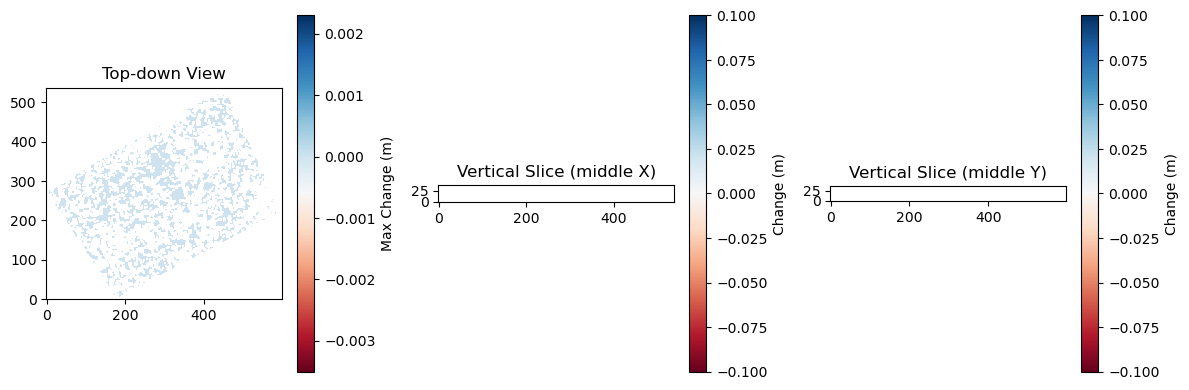

In [17]:
# 2D visualizations
topdown = np.load(f"voxel_diff_topdown_{voxel_size}.npy")

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(topdown, cmap="RdBu", origin='lower')
plt.colorbar(label="Max Change (m)")
plt.title("Top-down View")

plt.tight_layout()
plt.show()